In [ ]:
!pip install evaluate

In [ ]:
!pip install transformers

In [1]:
from transformers import BertForMaskedLM, AutoTokenizer

In [2]:
model = BertForMaskedLM.from_pretrained("prajjwal1/bert-medium")
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-medium")

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
tokenizer.bos_token, tokenizer.pad_token, tokenizer.sep_token, tokenizer.cls_token, tokenizer.mask_token, tokenizer.pad_token_id, tokenizer.sep_token_id, tokenizer.cls_token_id

Using bos_token, but it is not set yet.


(None, '[PAD]', '[SEP]', '[CLS]', '[MASK]', 0, 102, 101)

# **Data processing**

In [5]:
import json
import random
dataset = json.load(open("./dataset.json", "r"))
dataset = [i.strip(" .").split(" . ") for i in dataset]
all_post = []
all_len = []
for post in dataset:
    post = [
        tokenizer.tokenize(i) for i in post
    ]
    # for idx in range(1, len(post)):
    #     if len(post[idx-1]) < 10 or len(post[idx-1]) > 60 or len(post[idx]) < 10 or len(post[idx]) > 60:
    #         continue
    #     seq = ["CLS"] + post[idx-1] + [" . "] + post[idx] + [" . "] + ["SEP"]
    lens = [len(i) for i in post]  
    all_post.append(post)
    all_len += lens
from collections import Counter
ct = Counter(all_len)
max(all_len), min(all_len)

(87, 1)

Text(0.5, 1.0, 'Frequence of each sequence length in dataset')

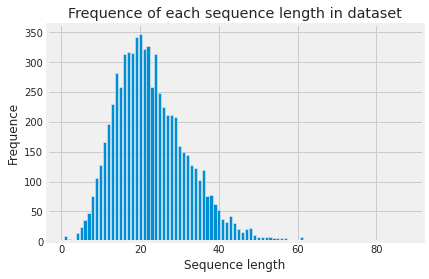

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

plt.bar(list(ct.keys()), list(ct.values()))
plt.ylabel("Frequence")
plt.xlabel("Sequence length")
plt.title("Frequence of each sequence length in dataset")

60 10


Text(0.5, 1.0, 'Frequence of each sequence length after split')

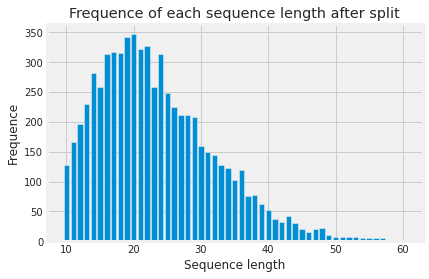

In [58]:
# Get in range [10, 60]
all_len = list(filter(lambda x: x >= 10 and x <= 60, all_len))
ct = Counter(all_len)
print(max(all_len), min(all_len))
plt.bar(list(ct.keys()), list(ct.values()))
plt.ylabel("Frequence")
plt.xlabel("Sequence length")
plt.title("Frequence of each sequence length after split")

106 20


Text(0.5, 1.0, 'Frequence of each sequence length after make pair sentence')

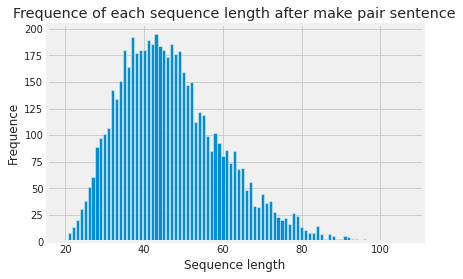

In [67]:
# Make pair sentences
all_len = []
all_seq = []
for post in all_post:
    for idx in range(1, len(post)):
        cur = post[idx]
        pre = post[idx-1]
        if len(pre) < 10 or len(cur) < 10 or len(pre) > 60 or len(cur) > 60:
            continue
        all_len.append(len(cur) + len(pre))
        cur = tokenizer.convert_tokens_to_string(cur)
        pre = tokenizer.convert_tokens_to_string(pre)
        seq = pre + ". " + cur
        all_seq.append(seq)
ct = Counter(all_len)
print(max(all_len), min(all_len))
plt.bar(list(ct.keys()), list(ct.values()))
plt.ylabel("Frequence")
plt.xlabel("Sequence length")
plt.title("Frequence of each sequence length after make pair sentence")

In [69]:
# Create test data
valid_seqs = []
for seq in all_seq:
    seq = tokenizer.tokenize(seq)
    if len(seq) < 75:
        continue 
    d = random.randint(40, 70)
    seq = seq[d:]
    seq = tokenizer.convert_tokens_to_string(seq)
    valid_seqs.append(seq)

In [70]:
print("Len of train dataset:", len(all_seq))
print("Len of valid dataset:", len(valid_seqs))

Len of train dataset: 5961
Len of valid dataset: 229


In [71]:
# Save data
def save_json(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f)
        f.close()
    print(f"[+] Save {filename} successfully")

save_json("./train.json", all_seq)
save_json("./valid.json", valid_seqs)

[+] Save ./train.json successfully
[+] Save ./valid.json successfully


# **Create CustomDataset**

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):

    def __init__(self, filename, tokenizer, max_len=128, mlm_prob=0.15):
        self.tokenizer = tokenizer
        self.mlm_prob = mlm_prob
        self.max_len = max_len
        self.__read_data(filename)

    def __read_data(self, filename):
        self.data = json.load(open(filename, "r"))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = self.tokenizer(self.data[idx], max_length=self.max_len, padding="max_length", return_tensors="pt")  
        input["labels"] = input.input_ids.detach().clone()
        mask = torch.rand((1, self.max_len)) <= self.mlm_prob
        mask = mask * (input.input_ids != self.tokenizer.cls_token_id) * (input.input_ids != self.tokenizer.sep_token_id) * (input.input_ids != self.tokenizer.pad_token_id)
        mask_idx = mask.nonzero()
        input.input_ids[0, mask_idx[:, 1]] = self.tokenizer.mask_token_id
        for k, v in input.items():
            v = v.squeeze()
            input[k] = v
        return input

In [39]:
train_dataset = CustomDataset("./train.json", tokenizer, mlm_prob=0.55)
valid_dataset = CustomDataset("./valid.json", tokenizer, mlm_prob=0.15)

In [40]:
train_dataset[10]

{'input_ids': tensor([  101,   103,  2026,   103,   103,   103,   103,   103,   103,  2023,
         9575,   103,   103,   103,   103,  3778,  1997,  2147,   103,  6360,
         7461,  2111,   103,   103,  5177,   103,   103,   103,   103,  2524,
          103,  2965,  2008,  2111,  2064,   103,  2131,   103,  1997,   103,
        16342,   103,   103,   103,  1010,   103,   103,   103,   103,  2051,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

# **Training Model**

In [10]:
import evaluate
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

In [ ]:
for name, param in model.named_parameters():
    if "cls.predictions." in name:
        param.requires_grad = True
    else:
        param.requires_grad = False 
    print(name, param.requires_grad)

In [12]:
def compute_metrics(pred):
    global tokenizer
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu = evaluate.load("bleu")
    results = bleu.compute(predictions=preds, references=labels)
    return {
        "bleu": results["bleu"],
        # "bleu": 1.0,
        "brevity_penalty": results["brevity_penalty"],
        "length_ratio": results["length_ratio"]
    }

In [45]:
training_args = TrainingArguments(
    output_dir="./checkpoint",
    overwrite_output_dir=True,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_strategy ="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-3,
    save_total_limit=1,
    warmup_steps=4000,
    warmup_ratio = 0.25,
    lr_scheduler_type='linear',
    # max_steps=4
)

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
trainer = Trainer(
    model=model.to("cuda"),
    compute_metrics=compute_metrics,              
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    # data_collator=collator,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Both warmup_ratio and warmup_steps given, warmup_steps will override any effect of warmup_ratio during training


In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5961
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14920
  Number of trainable parameters = 294202


Epoch,Training Loss,Validation Loss,Bleu,Brevity Penalty,Length Ratio
1,1.637600,0.461088,0.568392,1.000000,1.337281
2,0.980200,0.610702,0.513846,1.000000,1.487891
3,0.963300,0.503696,0.562284,1.000000,1.362736
4,0.956200,0.383676,0.606021,1.000000,1.252961


***** Running Evaluation *****
  Num examples = 229
  Batch size = 8
Saving model checkpoint to ./checkpoint/checkpoint-746
Configuration saved in ./checkpoint/checkpoint-746/config.json
Configuration saved in ./checkpoint/checkpoint-746/generation_config.json
Model weights saved in ./checkpoint/checkpoint-746/pytorch_model.bin
Deleting older checkpoint [checkpoint/checkpoint-4] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 229
  Batch size = 8
Saving model checkpoint to ./checkpoint/checkpoint-1492
Configuration saved in ./checkpoint/checkpoint-1492/config.json
Configuration saved in ./checkpoint/checkpoint-1492/generation_config.json
Model weights saved in ./checkpoint/checkpoint-1492/pytorch_model.bin
Deleting older checkpoint [checkpoint/checkpoint-746] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 229
  Batch size = 8
Saving model checkpoint to ./checkpoint/checkpoint-2238
Configuration saved in ./checkpoint/checkpoint-

In [26]:
!mkdir ./bert_model_weight_v1 && mkdir ./bert_tokenizer_weight_v1

tensor([  101,  1031,  1000,  1999,  2715,  2554,  1010,  2926,  1999,  2502,
         3655,  1010, 17319,  2524,  2147,  2038,  2468,  1037,  2200,  2590,
         3444,  1997,  6623,  2111,  1032, 23343, 24096,  2683,  2015, 10126,
         2166,   102])

In [ ]:
model.save_pretrained("./bert_model_weight_v1")
tokenizer.save_pretrained("./bert_tokenizer_weight_v1")

In [ ]:
!mv ./model_weight_v1 ./drive/MyDrive/checkpoint_bert && mv ./tokenizer_weight_v1 ./drive/MyDrive/checkpoint_bert 